# Import Libraries

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# import numpy as np
# print(np.__version__)

In [3]:
!pip install numpy==2.1.3

In [4]:
import numpy as np
print(np.__version__)

2.1.3


In [5]:
import pandas as pd
print(pd.__version__)

2.2.3


In [6]:
import random
import shutil
import tqdm
import glob
import os

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style("darkgrid")

In [8]:
from src.utils import float_to_int
from src.components.data_processing import data_processing

In [9]:
# Maximize column display 
pd.set_option("display.max_colwidth", None)     # Display all content within each cell without truncation
pd.set_option("display.max_columns", None)      # Display all columns
pd.set_option("display.width", None)            # Display entire width of DataFrame is displayed

pd.set_option("display.max_rows", None)         # Display all rows

# Load Data

In [10]:
def get_dates(dirpath: str, signal_id: str):
    """
    Retrieves a list of dates from the filepaths of .pkl files for a given signal ID.

    Parameters:
    -----------
    dirpath : str
        The directory path containing the data.
    signal_id : str
        The signal ID for which dates are to be extracted.

    Returns:
    --------
    list
        A list of dates extracted from the filenames of the .pkl files.

    Raises:
    -------
    FileNotFoundError
        If no .pkl files are found for the given signal ID.
    """
    # Step 1: Define the filepaths pattern for the given signal ID
    # The pattern will match all .pkl files in the specified directory for the signal ID
    filepaths = f"{dirpath}/{signal_id}/*.pkl"

    # Step 2: Use glob to get all matching file paths based on the pattern
    filepaths = [p for p in glob.glob(filepaths)]

    # Step 3: Check if any files exist for the given signal ID
    # If no files match the pattern, raise a FileNotFoundError with an appropriate message
    if not filepaths:
        raise FileNotFoundError(f"No files found for signal ID: {signal_id}")

    # Step 4: Extract the date portion from each filepath
    # Assume that filenames are in the format "<date>.pkl"
    # os.path.basename(filepath) extracts the filename from the full path
    # .split(".")[0] extracts the date part (before the ".pkl" extension)
    dates = [os.path.basename(filepath).split(".")[0] for filepath in filepaths]

    # Step 5: Return the list of extracted dates
    return dates

In [11]:
def load_and_merge_data(dirpath1: str, dirpath2: str, signal_id: str) -> pd.DataFrame:
    """
    Loads and merges two DataFrames for a given signal ID.

    Parameters:
    -----------
    dirpath1 : str
        The directory path containing the first set of data.
    dirpath2 : str
        The directory path containing the second set of data.
    signal_id : str
        The signal ID for which the data will be loaded and merged.

    Returns:
    --------
    pd.DataFrame
        The merged DataFrame containing data from both sources.

    Raises:
    -------
    FileNotFoundError
        If the files for the given signal ID and dates are mismatched or not found.
    Exception
        For any other errors encountered during processing.
    """
    try:
        # Step 1: Get the list of dates for the signal ID in both directories
        # This assumes a function `get_dates` exists that fetches dates for a given signal ID.
        dates1 = get_dates(dirpath=dirpath1, signal_id=signal_id)
        dates2 = get_dates(dirpath=dirpath2, signal_id=signal_id)

        # Step 2: Ensure the lists of dates are identical
        # If dates1 and dates2 don't match, raise a FileNotFoundError
        if dates1 != dates2:
            raise FileNotFoundError(f"Files to merge didn't match for signal ID: {signal_id}")

        # Step 3: Initialize an empty DataFrame to accumulate the merged data
        df = pd.DataFrame()

        # Step 4: Iterate through the list of dates to process files for each date
        for date in dates1:  # Note: dates2 can also be used since they are identical
            # Load the data for the current date from the first directory
            df1_date = pd.read_pickle(f"{dirpath1}/{signal_id}/{date}.pkl")

            # Load the data for the current date from the second directory
            df2_date = pd.read_pickle(f"{dirpath2}/{signal_id}/{date}.pkl")

            # Merge the two datasets using common columns
            # Common columns are assumed to include identifiers like "signalID", "cycleNo", etc.
            df_date = pd.merge(
                df1_date, df2_date,
                on=["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"]
            )

            # Append the merged data for the current date to the main DataFrame
            # `ignore_index=True` resets the index after concatenation
            df = pd.concat([df, df_date], axis=0, ignore_index=True)

        # Step 5: Return the final merged DataFrame
        return df

    except FileNotFoundError as fnf_error:
        # Handle case where files are not found or mismatched
        print(fnf_error)
        raise

    except Exception as e:
        # Handle any other exceptions and re-raise them for debugging
        print(f"Error occurred while loading and merging data: {e}")
        raise

In [12]:
def replace_and_filter_columns_with_mapping(df: pd.DataFrame, mapping: dict, keep_column_names: list) -> pd.DataFrame:
    """
    Replaces digits in column names based on a custom mapping and filters the DataFrame 
    to include renamed columns along with additional specified columns.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame whose column names need to be updated.
    mapping : dict
        A dictionary where keys are digits (as strings) and values are their replacements (e.g., {'1': 'L'}).
    keep_column_names : list
        A list of additional column names to include in the filtered DataFrame.

    Returns:
    --------
    pd.DataFrame
        A filtered DataFrame with updated column names and selected columns.
    """
    try:
        # Define a function to replace digits in column names based on the mapping
        def replace_digits_in_column(col_name):
            proc_col_name = ""
            for char in col_name:
                if char.isdigit() and char in mapping:  # Replace digits based on the mapping
                    proc_col_name += mapping[char]
                else:
                    proc_col_name += char  # Keep non-digit characters as is
            return proc_col_name

        # Replace column names based on the mapping
        dict_column_names = {col: replace_digits_in_column(col) for col in df.columns}
        dict_column_names = {key: val for key, val in dict_column_names.items() if key != val}
        df = df.rename(columns=dict_column_names)

        # Filter the columns to include renamed and additional columns
        keep_column_names = keep_column_names + [col for col in dict_column_names.values() if col in df.columns]
        df = df[keep_column_names]

        return df

    except Exception as e:
        print(f"Error occurred while replacing and filtering columns: {e}")
        raise

In [13]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the input DataFrame to create new features, transform data, and rename columns.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing signal cycle data.

    Returns:
    --------
    pd.DataFrame
        The processed DataFrame with additional features, updated values, and renamed columns.

    """
    try:

        # # Create "day" and "hour" features
        # df["day"] = df["cycleBegin"].dt.day  # Extract day from cycleBegin timestamp
        # df["hour"] = df["cycleBegin"].dt.hour  # Extract hour from cycleBegin timestamp

        # # Create "isWeekday" feature: 1 for weekdays (Mon-Fri), 0 for weekends (Sat-Sun)
        # df["isWeekday"] = df["cycleBegin"].dt.weekday.apply(lambda x: 0 if x >= 5 else 1)

        # Remove columns with red light running counts
        columns = [column for column in df.columns if "Cnt" not in column]
        df = df[columns]

        # Convert "Ratio" values to seconds
        for i in range(len(df)):
            cycle_length = df.at[i, "cycleLength"]

            for column in df.columns:
                if "Ratio" in column:  # Identify ratio columns
                    # Multiply the ratio by cycle length to get values in seconds
                    df.at[i, column] = cycle_length * df.at[i, column]

        # Rename columns by removing the word "Ratio"
        df = df.rename(columns=lambda x: x.replace("Ratio", "") if "Ratio" in x else x)

        return df

    except Exception as e:
        print(f"Error occurred while processing DataFrame: {e}")
        raise

In [14]:
signal_ids = ["1301", "1435", "1439"]

---

**Red Light Running By Left-Turning Vehicles**

---

In [15]:
# # Load and merge 
# df = pd.DataFrame()
# for signal_id in tqdm.tqdm(signal_ids):
#     tqdm.tqdm.write(f"Processing Signal ID: {signal_id}")

#     # Create a temporary folder
#     os.makedirs(f"../data/production/production/temp/{signal_id}", exist_ok=True)
    
#     # Load data
#     # Features: signal + occupancy
#     df_id = load_and_merge_data(dirpath1="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_signal/spat", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/occupancy", 
#                                 signal_id=signal_id)

#     for date in df_id["date"].unique():
#         df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")

#     # # Features: signal + occupancy + split failure
#     # df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#     #                             dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/split_failure", 
#     #                             signal_id=signal_id)

#     # for date in df_id["date"].unique():
#     #     df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")


#     # Features: signal + occupancy + red light running
#     df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/red_running", 
#                                 signal_id=signal_id)
    
#     # Remove temporary folder
#     shutil.rmtree("../data/production/production/temp")

#     # Specify the mapping for replacements
#     dict_mapping = {'1': 'L', '5': 'L'} # Left-turning phases

#     # Specify additional columns to include
#     keep_column_names = ["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"]
    
#     for key, val in dict_mapping.items():
#         # Replace and filter columns
#         df_phase = replace_and_filter_columns_with_mapping(df=df_id, 
#                                                            mapping={key: val}, 
#                                                            keep_column_names=keep_column_names)
        
#         df_phase = process_df(df=df_phase)
#         df_phase["key"] = key

#         df = pd.concat([df, df_phase], axis=0, ignore_index=True)

# df.to_csv("../data/production/production/left+thru/left.csv", index=False)

In [16]:
df_by_left = pd.read_csv("../data/production/production/left+thru/left.csv")

print(df_by_left.shape)
df_by_left.head(1)

(106464, 37)


,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,redClearanceRunningFlagPhaseL,redRunningFlagPhaseL,key
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,7.79976,5.49792,2.00376,67.49856,[3.9],3.9,3.9,3.9,0.0,[np.float64(3.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[25.7],25.7,25.7,25.7,0.0,[np.float64(25.7)],0.0,0.0,1


---

**Red Light Running By Through Vehicles**

---

In [17]:
# # Load and merge 
# df = pd.DataFrame()
# for signal_id in tqdm.tqdm(signal_ids):
#     tqdm.tqdm.write(f"Processing Signal ID: {signal_id}")

#     # Create a temporary folder
#     os.makedirs(f"../data/production/production/temp/{signal_id}", exist_ok=True)
    
#     # Load data
#     # Features: signal + occupancy
#     df_id = load_and_merge_data(dirpath1="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_signal/spat", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/occupancy", 
#                                 signal_id=signal_id)

#     for date in df_id["date"].unique():
#         df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")

#     # # Features: signal + occupancy + split failure
#     # df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#     #                             dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/split_failure", 
#     #                             signal_id=signal_id)

#     # for date in df_id["date"].unique():
#     #     df_id.to_pickle(f"../data/production/production/temp/{signal_id}/{date.year}-{date.month:02d}-{date.day:02d}.pkl")


#     # Features: signal + occupancy + red light running
#     df_id = load_and_merge_data(dirpath1="../data/production/production/temp", 
#                                 dirpath2="../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/red_running", 
#                                 signal_id=signal_id)
    
#     # Remove temporary folder
#     shutil.rmtree("../data/production/production/temp")

#     # Specify the mapping for replacements
#     dict_mapping = {'6': 'T', '2': 'T'} # through phases

#     # Specify additional columns to include
#     keep_column_names = ["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"]
    
#     for key, val in dict_mapping.items():
#         # Replace and filter columns
#         df_phase = replace_and_filter_columns_with_mapping(df=df_id, 
#                                                            mapping={key: val}, 
#                                                            keep_column_names=keep_column_names)
        
#         df_phase = process_df(df=df_phase)
#         df_phase["key"] = key

#         df = pd.concat([df, df_phase], axis=0, ignore_index=True)

# df.to_csv("../data/production/production/left+thru/thru.csv", index=False)

In [18]:
df_by_thru = pd.read_csv("../data/production/production/left+thru/thru.csv")

print(df_by_thru.shape)
df_by_thru.head(1)

(106464, 37)


,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,redClearanceRunningFlagPhaseT,redRunningFlagPhaseT,key
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,38.502,11.00412,3.99924,29.30292,[1.9],1.9,1.9,1.9,0.0,[np.float64(1.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],0.0,0.0,6


## Red Light Running By (Left-Turning+Through) Vehicles

In [19]:
# Merge data -- (1, 6), (5, 2)

# df_by_left.info()
# df_by_thru.info()

df_by_left["key"] = df_by_left["key"].replace({1: 1, 5: 2})
df_by_thru["key"] = df_by_thru["key"].replace({6: 1, 2: 2})

df = pd.merge(df_by_left, df_by_thru, 
              on=["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength", "key"], 
              how="inner")

print(df.shape)
df.head(1)

(106464, 67)


,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,redClearanceRunningFlagPhaseL,redRunningFlagPhaseL,key,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,redClearanceRunningFlagPhaseT,redRunningFlagPhaseT
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,7.79976,5.49792,2.00376,67.49856,[3.9],3.9,3.9,3.9,0.0,[np.float64(3.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[25.7],25.7,25.7,25.7,0.0,[np.float64(25.7)],0.0,0.0,1,38.502,11.00412,3.99924,29.30292,[1.9],1.9,1.9,1.9,0.0,[np.float64(1.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],0.0,0.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106464 entries, 0 to 106463
Data columns (total 67 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   signalID                            106464 non-null  int64  
 1   cycleNo                             106464 non-null  int64  
 2   date                                106464 non-null  object 
 3   cycleBegin                          106464 non-null  object 
 4   cycleEnd                            106464 non-null  object 
 5   cycleLength                         106464 non-null  float64
 6   greenPhaseL                         106464 non-null  float64
 7   yellowPhaseL                        106464 non-null  float64
 8   redClearancePhaseL                  106464 non-null  float64
 9   redPhaseL                           106464 non-null  float64
 10  greenOccupancyPhaseL                101202 non-null  object 
 11  greenMinOccupancyPhaseL   

---

**Missing Value**

---

In [21]:
df[pd.isna(df["greenOccupancyPhaseL"])].head(1)

,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,redClearanceRunningFlagPhaseL,redRunningFlagPhaseL,key,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,redClearanceRunningFlagPhaseT,redRunningFlagPhaseT
13376,1301,3,2024-01-29,2024-01-29 00:01:56.400,2024-01-29 00:03:30.300,93.9,34.99653,5.50254,2.00007,51.40086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,57.50436,5.50254,2.00007,28.90242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.isna().mean() * 100

signalID                              0.000000
cycleNo                               0.000000
date                                  0.000000
cycleBegin                            0.000000
cycleEnd                              0.000000
cycleLength                           0.000000
greenPhaseL                           0.000000
yellowPhaseL                          0.000000
redClearancePhaseL                    0.000000
redPhaseL                             0.000000
greenOccupancyPhaseL                  4.942516
greenMinOccupancyPhaseL               4.942516
greenMaxOccupancyPhaseL               4.942516
greenAvgOccupancyPhaseL               4.942516
greenStdOccupancyPhaseL               4.942516
greenSumListOccupancyPhaseL           4.942516
yellowOccupancyPhaseL                 4.942516
yellowMinOccupancyPhaseL              4.942516
yellowMaxOccupancyPhaseL              4.942516
yellowAvgOccupancyPhaseL              4.942516
yellowStdOccupancyPhaseL              4.942516
yellowSumList

**Missing Value Summary:**

- Error results from sensor failure.
- Error is <5%.

In [23]:
df = df.dropna()
df.shape

(101202, 67)

---

**Duplicates**

---

In [24]:
df.duplicated().sum()

np.int64(0)

# Exploratory Data Analysis

## Target Feature

In [25]:
# Change dtype (float -- int)
for column in df.columns:
    if "RunningFlag" in column:
        df = df.copy()
        df[column] = float_to_int(df[[column]])

In [26]:
# Summary of (unintentional + intentional) red light running
data_processing.target_summary(df)

,featureName,Not Red Run (0),Red Run (1)
0,redClearanceRunningFlagPhaseL,95025,6177
1,redRunningFlagPhaseL,64075,37127
2,redClearanceRunningFlagPhaseT,91609,9593
3,redRunningFlagPhaseT,71408,29794


**(Unintentional) Red Light Running:**

- "redClearanceRunningFlagPhaseL" and "redClearanceRunningFlagPhaseT"

In [27]:
# Drop (intentional) red light running
df = df.drop(columns=["redRunningFlagPhaseL", "redRunningFlagPhaseT"])

In [32]:
# Compress (unintentional) red light running columns into target column
columns = ["redClearanceRunningFlagPhaseL", "redClearanceRunningFlagPhaseT"]

df["uRedRunningFlag"] = df[columns].apply(lambda row: 1 if (row == 1).any() else 0, 
                                          axis=1) # if any phase experience red light run

df = df.drop(columns=columns)
df.head(1)

,signalID,cycleNo,date,cycleBegin,cycleEnd,cycleLength,greenPhaseL,yellowPhaseL,redClearancePhaseL,redPhaseL,greenOccupancyPhaseL,greenMinOccupancyPhaseL,greenMaxOccupancyPhaseL,greenAvgOccupancyPhaseL,greenStdOccupancyPhaseL,greenSumListOccupancyPhaseL,yellowOccupancyPhaseL,yellowMinOccupancyPhaseL,yellowMaxOccupancyPhaseL,yellowAvgOccupancyPhaseL,yellowStdOccupancyPhaseL,yellowSumListOccupancyPhaseL,redClearanceOccupancyPhaseL,redClearanceMinOccupancyPhaseL,redClearanceMaxOccupancyPhaseL,redClearanceAvgOccupancyPhaseL,redClearanceStdOccupancyPhaseL,redClearanceSumListOccupancyPhaseL,redOccupancyPhaseL,redMinOccupancyPhaseL,redMaxOccupancyPhaseL,redAvgOccupancyPhaseL,redStdOccupancyPhaseL,redSumListOccupancyPhaseL,key,greenPhaseT,yellowPhaseT,redClearancePhaseT,redPhaseT,greenOccupancyPhaseT,greenMinOccupancyPhaseT,greenMaxOccupancyPhaseT,greenAvgOccupancyPhaseT,greenStdOccupancyPhaseT,greenSumListOccupancyPhaseT,yellowOccupancyPhaseT,yellowMinOccupancyPhaseT,yellowMaxOccupancyPhaseT,yellowAvgOccupancyPhaseT,yellowStdOccupancyPhaseT,yellowSumListOccupancyPhaseT,redClearanceOccupancyPhaseT,redClearanceMinOccupancyPhaseT,redClearanceMaxOccupancyPhaseT,redClearanceAvgOccupancyPhaseT,redClearanceStdOccupancyPhaseT,redClearanceSumListOccupancyPhaseT,redOccupancyPhaseT,redMinOccupancyPhaseT,redMaxOccupancyPhaseT,redAvgOccupancyPhaseT,redStdOccupancyPhaseT,redSumListOccupancyPhaseT,uRedRunningFlag
0,1301,3,2024-01-01,2024-01-01 00:02:28.100,2024-01-01 00:03:50.900,82.8,7.79976,5.49792,2.00376,67.49856,[3.9],3.9,3.9,3.9,0.0,[np.float64(3.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[25.7],25.7,25.7,25.7,0.0,[np.float64(25.7)],1,38.502,11.00412,3.99924,29.30292,[1.9],1.9,1.9,1.9,0.0,[np.float64(1.9)],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],[0],0.0,0.0,0.0,0.0,[0],0


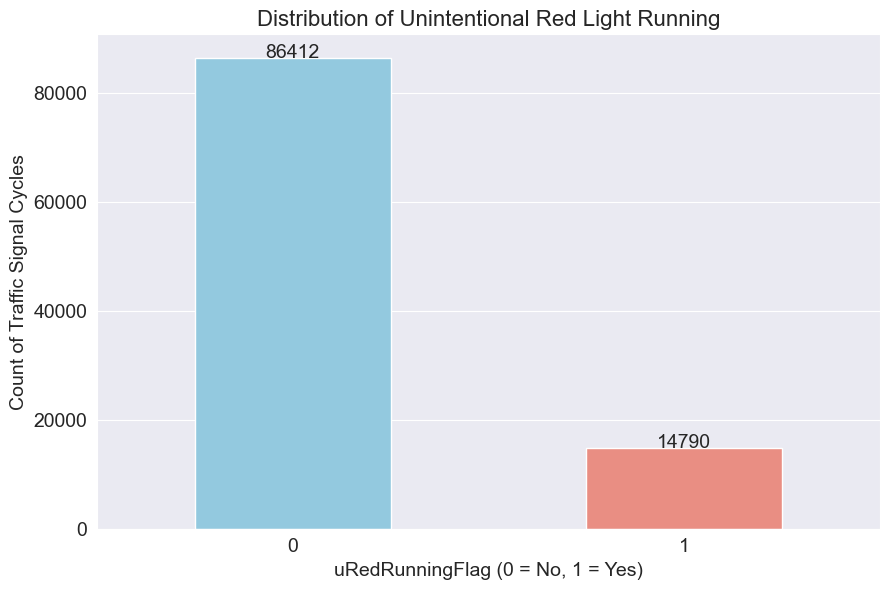

In [56]:
# Distribution of (unintentional + intentional) red light running
value_counts = df["uRedRunningFlag"].value_counts()

plt.figure(figsize=(9, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette=["skyblue", "salmon"], width=0.5)

plt.xlabel("uRedRunningFlag (0 = No, 1 = Yes)", fontsize=14)
plt.ylabel("Count of Traffic Signal Cycles", fontsize=14)
plt.title("Distribution of Unintentional Red Light Running", fontsize=16)
plt.xticks([0, 1])
# plt.xticks(ticks=[0, 1], labels=["No", "Yes"], fontsize=14)

# Setting font size for ticks
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

# Adding count labels on top of each bar
for index, value in enumerate(value_counts.values):
    plt.text(index, value + 0.25, str(value), ha="center", fontsize=14)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../reports/target_distribution.png", dpi=300)
plt.show()

## Target

In [ ]:
target_summary(df=df_data)

In [ ]:
target_summary(df=df_data).to_csv("../report/target_summary.csv", index=False)

In [ ]:
dict_red_run_columns = {
    # "IntentLeft": ["redRunFlagPhase1", "redRunFlagPhase5"],
    # "IntentThru": ["redRunFlagPhase2", "redRunFlagPhase6"],

    "UnintentLeft": ["redClearanceRunFlagPhase1", "redClearanceRunFlagPhase5"],
    "UnintentThru": ["redClearanceRunFlagPhase2", "redClearanceRunFlagPhase6"]
}

In [ ]:
# Compress run red columns into target column
for key in tqdm.tqdm(dict_red_run_columns.keys()):
    df_data[f"redRun{key}"] = df_data[dict_red_run_columns[key]].apply(lambda row: 1 if (row == 1).any() else 0, 
                                                                       axis=1) # if any phase experience red light run

    # Drop all red run columns, except the compressed target column
    df_data = df_data.drop(columns=dict_red_run_columns[key])

df_data = df_data.drop(columns=["redRunFlagPhase1", "redRunFlagPhase5", "redRunFlagPhase2", "redRunFlagPhase6"])
df_data.head(1)

In [ ]:
# List of the red light running columns
target_columns = [
    # "redRunIntentLeft", "redRunIntentThru", 
    "redRunUnintentLeft", "redRunUnintentThru"
]

# Creating the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Red Light Running Count", fontsize=18)

# Iterate over each column and create a bar plot
for i, col in enumerate(target_columns):
    ax = axes[i]
    value_counts = df_data[col].value_counts()

    sns.barplot(x=value_counts.index, y=value_counts.values, palette=["skyblue", "salmon"], ax=ax)

    ax.set_xlabel(f"{col} (0 = No, 1 = Yes)", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(f"Distribution of {col}", fontsize=16)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["No", "Yes"])

    # Setting font size for ticks
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    
    # Adding count labels on top of each bar
    for index, value in enumerate(value_counts.values):
        ax.text(index, value + 0.1, str(value), ha="center", fontsize=14)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../report/target_distribution.png", dpi=300)
plt.show()

In [ ]:
# df_data.date.dtypes

In [ ]:
# List of the red light running columns
target_columns = [
    # "redRunIntentLeft", "redRunIntentThru", 
    "redRunUnintentLeft", "redRunUnintentThru"
]

# Resample to hourly and take the max, keeping the result as integers
df_hourly = (
    df_data[target_columns + ["cycleBegin"]]
    .set_index("cycleBegin")
    .resample("H")
    .sum()
    .fillna(0)  # Replace NaN values with 0
    .astype(int)  # Convert to integer type
)

df_hourly["day"] = df_hourly.index.date; df_hourly["hour"] = df_hourly.index.hour

# Plotting hourly trend lines for each feature with day as hue in a 4-row, 1-column layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plotting each feature"s hourly trend line with day as hue
for i, column in enumerate(target_columns):
    sns.lineplot(
        data=df_hourly,
        x="hour",
        y=column,
        ax=axes[i],
        marker="o"
    )
    
    axes[i].set_title(f"Hourly Trend of {column} by Day", fontsize=16)
    axes[i].set_xlabel("Hour of Day", fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    axes[i].set_xticks(range(24))
    axes[i].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45, fontsize=12)
    
    # Setting y-ticks as integers and customizing labels
    y_max = int(df_hourly[column].max()) - 5
    axes[i].set_yticks(range(0, y_max))
    axes[i].set_yticklabels([str(tick) for tick in range(0, y_max)], fontsize=12)
    
    axes[i].grid(True)
    # axes[i].legend(title="Day", fontsize=10, loc="upper_right")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("../report/target_trend.png", dpi=300)
plt.show()

## Independent Features

In [ ]:
# Create hour", and "day" features
df_data["day"] = df_data["cycleBegin"].dt.day; df_data["hour"] = df_data["cycleBegin"].dt.hour

# Create feature "isWeekday": 1 for weekday (Mon-Fri), 0 for weekend (Sat-Sun)
df_data["isWeekday"] = df_data["cycleBegin"].dt.weekday.apply(lambda x: 0 if x >= 5 else 1)

In [ ]:
df_data.head(1)

In [ ]:
# Convert ratio to seconds
for i in tqdm.tqdm(range(len(df_data))):
    cycle_length = df_data.at[i, "cycleLength"]

    for column in df_data.columns:
        if "Ratio" in column:
            df_data.at[i, column] = cycle_length * df_data.at[i, column]


# Rename columns that contain 'Ratio' by removing the word 'Ratio'
df_data = df_data.rename(columns=lambda x: x.replace("Ratio", "") if "Ratio" in x else x)

In [ ]:
columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# Creating a figure for Seaborn boxplots
plt.figure(figsize=(20, 10))

# Using Seaborn's boxplot function to visualize outliers
sns.boxplot(data=df_data[columns], color="salmon")

plt.title("Outlier Detection", fontsize=20)
plt.xlabel("Signal Phases", fontsize=18)
plt.ylabel("Duration (seconds)", fontsize=18)
plt.xticks(rotation=90)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.tight_layout()
plt.savefig("../report/feature_distribution.png", dpi=300)
plt.show()

In [ ]:
# # Applying the IQR method to filter out outliers for each column in the dataset.
# def remove_outliers(df, columns):
#     # Create a copy of the DataFrame to avoid modifying the original data
#     proc_df = df.copy()

#     # Cutoffs
#     cutoffs = []
    
#     # Loop through each column to calculate IQR and filter out outliers
#     for column in columns:
#         # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1

#         # Define lower and upper bounds for outlier detection
#         lower_bound = max(0, Q1 - 1.5 * IQR)  # Adjust lower bound to be at least 0
#         upper_bound = Q3 + 1.5 * IQR

#         # Store the results
#         cutoffs.append({
#             'Feature': column,
#             'Lower Bound': lower_bound,
#             'Upper Bound': upper_bound
#         })

#         # Filter out outliers
#         proc_df = proc_df[(proc_df[column] >= lower_bound) & (proc_df[column] <= upper_bound)]

#     # Create a DataFrame for the cutoffs
#     df_cutoff = pd.DataFrame(cutoffs)

#     return proc_df, df_cutoff

# columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# # Applying the IQR outlier removal method to the dataset
# proc_df_data, df_cutoff = remove_outliers(df=df_data, columns=columns)

In [ ]:
# df_cutoff.head()

In [ ]:
# columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# # Creating a figure for Seaborn boxplots
# plt.figure(figsize=(20, 10))

# # Using Seaborn's boxplot function to visualize outliers
# sns.boxplot(data=proc_df_data[columns], color="salmon")

# plt.title("After Outlier Removal", fontsize=20)
# plt.xlabel("Signal Phases", fontsize=18)
# plt.ylabel("Duration (seconds)", fontsize=18)
# plt.xticks(rotation=90)

# plt.tick_params(axis="x", labelsize=16)
# plt.tick_params(axis="y", labelsize=16)

# plt.tight_layout()

# plt.show()

# Train-Test Split

In [ ]:
# Sample dates considering weekend and weekday
dict_dates = {
    "weekend_dates": df_data[df_data["isWeekday"] == 0]["date"].unique().tolist(),
    "weekday_dates": df_data[df_data["isWeekday"] == 1]["date"].unique().tolist(),
}

# Get train and export
train_dates = []
for key in dict_dates.keys():
    random.seed(906)
    train_dates = train_dates + random.sample(dict_dates[key], int(len(dict_dates[key]) * 0.75))

df_train = df_data[df_data.date.isin(train_dates)].reset_index(drop=True)
df_train.to_csv("../data/production/train.csv", index=False)

# Get test and export
df_test = df_data[~df_data.date.isin(train_dates)].reset_index(drop=True)
df_test.to_csv("../data/production/test.csv", index=False)

In [ ]:
# Summary of target: Red Light Running
def target_summary(df):
    dict_target = {"featureName": [], "Not Red Run (0)": [], "Red Run (1)": []}
    for column in df.columns:
        if "redRun" in column:
            dict_target["featureName"].append(column)
    
            values = df[column].values.tolist()
            
            dict_target["Not Red Run (0)"].append(values.count(0))
            dict_target["Red Run (1)"].append(values.count(1))

    df_target = pd.DataFrame(dict_target)
    return df_target

In [ ]:
print("Distribution of Target in Train Data:")
print(f'{target_summary(df=df_train)}\n')

print('Distribution of Target in Test Data:')
print(target_summary(df=df_test))